# Validation Check

In [1]:
# load libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate api & check for round
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 319


In [3]:
# era corr function
def compute_corr_by_era(val_df, model_list, corr_method):
    df_list = []
    for m in model_list:
        r = val_df.groupby("era")[["target", m]].corr(method=corr_method).iloc[0::2, -1]
        df = pd.DataFrame(r)
        df_list.append(r)
    df_all = pd.concat(df_list, axis=1).dropna().reset_index()
    return df_all.drop("level_1", axis=1).set_index("era")

---
# Load validation datesets

In [4]:
# read current round's validation preds
validation_data = pd.read_parquet('data/validation.parquet', columns=["era", "target"]).reset_index()
baseline_val = pd.read_csv(f"predictions/dh_baseline_val_preds.csv")
foxhound_val = pd.read_csv(f"predictions/dh_foxhound_val_preds.csv")
deadcell_val = pd.read_csv(f"predictions/dh_deadcell_val_preds.csv")
deadcellv2_val = pd.read_csv(f"predictions/dh_deadcellv2_val_preds.csv")
cobra_val = pd.read_csv(f"predictions/dh_cobra_val_preds.csv")
beautybeast_val = pd.read_csv(f"predictions/dh_beautybeast_val_preds.csv")
skulls_val = pd.read_csv(f"predictions/dh_skulls_val_preds.csv")
desperado_val = pd.read_csv(f"predictions/dh_desperado_val_preds.csv")
gaia_val = pd.read_csv(f"predictions/dh_gaia_val_preds.csv")

print(f"""
    Numerai validation     : {len(validation_data)}
    Foxhound predictions   : {len(baseline_val)}
    Foxhound predictions   : {len(foxhound_val)}
    Deadcell pedictions    : {len(deadcell_val)}
    Deadcellv2 pedictions  : {len(deadcellv2_val)}
    Cobra pedictions       : {len(cobra_val)}
    BeautyBeast pedictions : {len(beautybeast_val)}
    Skulls pedictions      : {len(skulls_val)}
    Desperado pedictions   : {len(desperado_val)}
    Gaia pedictions        : {len(gaia_val)}
    """)


    Numerai validation     : 2203644
    Foxhound predictions   : 2240650
    Foxhound predictions   : 2203644
    Deadcell pedictions    : 2203644
    Deadcellv2 pedictions  : 2203644
    Cobra pedictions       : 2203644
    BeautyBeast pedictions : 2203644
    Skulls pedictions      : 2203644
    Desperado pedictions   : 2203644
    Gaia pedictions        : 2214309
    


In [5]:
# join as master validation set
val = validation_data.merge(
    right=baseline_val, how='inner', on="id").merge(
    right=foxhound_val, how='inner', on="id", suffixes=('', '2')).merge(
    right=deadcell_val, how='inner', on="id", suffixes=('', '3')).merge(
    right=deadcellv2_val, how='inner', on="id", suffixes=('', '4')).merge(
    right=cobra_val, how='inner', on="id", suffixes=('', '5')).merge(
    right=beautybeast_val, how='inner', on="id", suffixes=('', '6')).merge(
    right=skulls_val, how='inner', on="id", suffixes=('', '7')).merge(
    right=desperado_val, how='inner', on="id", suffixes=('', '8')).merge(
    right=gaia_val, how='inner', on="id", suffixes=('', '9'))

val.columns = [
    "id", "era", "target", "baseline", "foxhound", "deadcell", "deadcellv2", 
    "cobra", "beautybeast", "skulls", "desperado", "gaia"
]
val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2203644 entries, 0 to 2203643
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   era          object 
 2   target       float32
 3   baseline     float64
 4   foxhound     float64
 5   deadcell     float64
 6   deadcellv2   float64
 7   cobra        float64
 8   beautybeast  float64
 9   skulls       float64
 10  desperado    float64
 11  gaia         float64
dtypes: float32(1), float64(9), object(2)
memory usage: 210.2+ MB


In [6]:
# view data
val.head()

,id,era,target,baseline,foxhound,deadcell,deadcellv2,cobra,beautybeast,skulls,desperado,gaia
0,n000101811a8a843,0575,0.50,0.412906,0.129369,0.083149,0.160607,0.021469,0.113878,0.167100,0.102993,0.115393
1,n001e1318d5072ac,0575,0.00,0.737539,0.439908,0.511116,0.523625,0.757530,0.829601,0.809236,0.669478,0.496547
2,n002a9c5ab785cbb,0575,0.50,0.331632,0.834553,0.442237,0.297244,0.753046,0.823740,0.417082,0.654132,0.733283
3,n002ccf6d0e8c5ad,0575,0.25,0.779142,0.929264,0.899298,0.817115,0.966960,0.997238,0.967952,0.952142,0.834736
4,n0051ab821295c29,0575,0.50,0.613395,0.169530,0.265021,0.474752,0.082918,0.142973,0.364021,0.204893,0.290528


---
# Get correlation by era

In [7]:
# models
prod_model_names = ["baseline", "foxhound", "deadcell", "cobra", "beautybeast", "skulls", "desperado"]
dev_model_names = ["baseline", "deadcellv2", "gaia"]

In [8]:
# get corrs
prod_pearson_corr = compute_corr_by_era(val_df=val, model_list=prod_model_names, corr_method="pearson")
prod_spearman_corr = compute_corr_by_era(val_df=val, model_list=prod_model_names, corr_method="spearman")
dev_pearson_corr = compute_corr_by_era(val_df=val, model_list=dev_model_names, corr_method="pearson")
dev_spearman_corr = compute_corr_by_era(val_df=val, model_list=dev_model_names, corr_method="spearman")

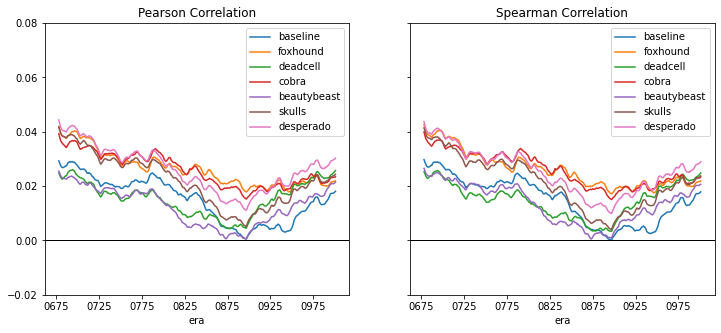

In [9]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
prod_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
prod_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].axhline(0, color ='black', linewidth=1)
axes[0].set_ylim(-0.02, 0.08)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

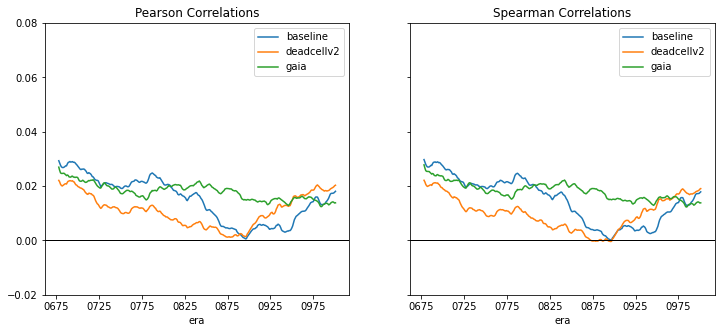

In [10]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
dev_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
dev_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlations")
axes[0].set_ylim(-0.02, 0.08)
axes[0].axhline(0, color ='black', linewidth=1)
axes[1].set_title("Spearman Correlations")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

---
# Get Sharp Ratio by models

In [11]:
# compute sharpe ratio (prod models)
prod_sharpe_df = pd.concat([
    (prod_pearson_corr.mean() / prod_pearson_corr.std()),
    (prod_spearman_corr.mean() / prod_spearman_corr.std())], axis=1)

prod_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(prod_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.62,0.60
foxhound,1.01,0.99
deadcell,0.62,0.59
cobra,0.98,0.97
beautybeast,0.61,0.60
skulls,0.79,0.76
desperado,0.90,0.86


In [12]:
# compute sharpe ratio (dev models)
dev_sharpe_df = pd.concat([
    (dev_pearson_corr.mean() / dev_pearson_corr.std()),
    (dev_spearman_corr.mean() / dev_spearman_corr.std())], axis=1)

dev_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(dev_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.62,0.60
deadcellv2,0.52,0.47
gaia,0.82,0.83


---
# Get percent of time the model was top ranked

In [13]:
# compute pct rank of validation era each model
pearson_rank_per_era = prod_pearson_corr.rank(axis=1, ascending=False)
spearman_rank_per_era = prod_spearman_corr.rank(axis=1, ascending=False)

rank_as_top = pd.concat([
    pd.DataFrame({
        "baseline": [np.sum([r for r in pearson_rank_per_era["baseline"] if r == 1])],
        "foxhound": [np.sum([r for r in pearson_rank_per_era["foxhound"] if r == 1])],
        "deadcell": [np.sum([r for r in pearson_rank_per_era["deadcell"] if r == 1])],
        "cobra": [np.sum([r for r in pearson_rank_per_era["cobra"] if r == 1])],
        "beautybeast": [np.sum([r for r in pearson_rank_per_era["beautybeast"] if r == 1])],
        "skulls": [np.sum([r for r in pearson_rank_per_era["skulls"] if r == 1])],
        "desperado": [np.sum([r for r in pearson_rank_per_era["desperado"] if r == 1])],
    }) / len(pearson_rank_per_era.index),
    pd.DataFrame({
        "baseline": [np.sum([r for r in spearman_rank_per_era["baseline"] if r == 1])],
        "foxhound": [np.sum([r for r in spearman_rank_per_era["foxhound"] if r == 1])],
        "deadcell": [np.sum([r for r in spearman_rank_per_era["deadcell"] if r == 1])],
        "cobra": [np.sum([r for r in spearman_rank_per_era["cobra"] if r == 1])],
        "beautybeast": [np.sum([r for r in spearman_rank_per_era["beautybeast"] if r == 1])],
        "skulls": [np.sum([r for r in spearman_rank_per_era["skulls"] if r == 1])],
        "desperado": [np.sum([r for r in spearman_rank_per_era["desperado"] if r == 1])],
    }) / len(spearman_rank_per_era.index),
])

rank_as_top.index = ["pearson_corr", "spearman_corr"]
round(rank_as_top, 2)


,baseline,foxhound,deadcell,cobra,beautybeast,skulls,desperado
pearson_corr,0.12,0.23,0.09,0.23,0.11,0.1,0.12
spearman_corr,0.11,0.24,0.10,0.23,0.12,0.1,0.10


---
# Submit for validation diagnosis

In [30]:
# read model name json file
with open("data/model_names.json", "r") as f:
    model_names = json.load(f)

model_names

{'dh_foxhound': '4d9bcd2c-69cb-4e17-a3f3-a4b2530cbcb8',
 'dh_deadcell': 'df8e47ff-b123-42a1-8145-a55b19be6a99',
 'dh_cobra': 'fe228762-f88a-4d09-9478-d02ae849a58a',
 'dh_beautybeast': '48c649b4-068b-483f-b370-770d55247b8d',
 'dh_skulls': '1296c746-5f1d-44af-a197-7f21e933dac9',
 'dh_desperado': '547bed40-6905-4f13-945d-de77d99e0487',
 'dh_gaia': '23d7378d-a7b4-425b-b67e-77b4bc3d4ccd'}

In [32]:
# single model submission
model_to_submit = "dh_gaia"

napi.upload_diagnostics(
    file_path=f"predictions/{model_to_submit}_val_preds.csv",
    model_id=model_names[f"{model_to_submit}"]
)

2022-06-09 20:43:20,396 INFO numerapi.base_api: uploading diagnostics...


'6bc7f523-a131-469a-9240-3b764b91ac37'

In [ ]:
# # submit validation predictions for diagnosis
# for item in model_names.items():
#     print(f"Submitting validation predictions for: {item[0]}...")
#     napi.upload_diagnostics(
#         file_path=f"predictions/{item[0]}_val_preds.csv",
#         model_id=item[1]
#     )